In [1]:
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix


from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

warnings.filterwarnings("ignore")


In [2]:
file=r"C:\Users\chira\Desktop\IDS\SensorNetGuard A Dataset for Identifying Malicious Sensor Nodes.csv"
df= pd.read_csv(file)

df.head(5)

,Node_ID,Timestamp,IP_Address,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,...,Number_of_Neighbors,Route_Request_Frequency,Route_Reply_Frequency,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,Is_Malicious
0,1,01-02-23 0:00,192.168.119.138,52.018229,2.727317,0.955687,130.967180,-52.059232,23.974265,82.982598,...,3,11.323044,11.458199,20.670539,14.385439,0.109146,26.376693,29.186341,76.811986,0
1,2,01-02-23 0:01,192.168.225.56,59.504648,1.435058,1.228460,82.634358,-57.754723,22.572052,66.734853,...,6,8.277362,8.832980,15.555122,14.316681,0.077136,34.963429,34.203177,112.495912,0
2,3,01-02-23 0:02,192.168.187.210,34.118204,1.320905,1.015245,61.649928,-52.399037,15.667076,74.593605,...,5,8.196374,8.330227,19.470748,11.792084,0.052993,48.934585,31.682662,117.526109,0
3,4,01-02-23 0:03,192.168.78.245,39.643055,1.988791,0.784562,69.704181,-53.727443,20.286962,76.710564,...,6,10.683766,6.525032,16.228955,8.895409,0.087810,47.045600,37.470027,123.058913,0
4,5,01-02-23 0:04,192.168.233.229,40.212679,1.005121,1.412193,123.445612,-49.696620,24.318538,84.477890,...,7,11.176823,10.617432,12.257423,10.168739,0.068823,33.394354,26.582970,71.696911,0


In [3]:
def preprocess_timeseries_data(df, timestamp_column):
    """
    Preprocesses the time series data by parsing timestamps, sorting, and setting the index.
    Extracts only day, hour, minute, and second features.
    
    Args:
    df (pd.DataFrame): The dataframe containing the timestamp column.
    timestamp_column (str): The name of the timestamp column to preprocess.
    
    Returns:
    pd.DataFrame: The dataframe with the timestamp column parsed, sorted, and set as the index,
                  with only day, hour, minute, and second features extracted.
    """
    
    # Ensure the timestamp column is in datetime format with the specified format
    df[timestamp_column] = pd.to_datetime(df[timestamp_column], format='%m-%d-%y %H:%M')
    
    # Sort the dataframe by the timestamp column
    df = df.sort_values(by=timestamp_column)
    
    # Set the timestamp column as the index
    df.set_index(timestamp_column, inplace=True)
    
    # Extract only day, hour, minute, and second features
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['second'] = df.index.second
    
    return df

def ip_to_int(ip):
    """Convert an IPv4 address to an integer."""
    parts = ip.split('.')
    ip_int = (int(parts[0]) << 24) + (int(parts[1]) << 16) + (int(parts[2]) << 8) + int(parts[3])
    return ip_int

In [4]:
df=preprocess_timeseries_data(df,"Timestamp")

df["IP_Address"]=df["IP_Address"].apply(lambda x :ip_to_int(x))

In [5]:
from sklearn.preprocessing import QuantileTransformer

numeric_features = df.dtypes[df.dtypes != 'object'].index



In [6]:
X = df.drop('Is_Malicious', axis=1)
y = df['Is_Malicious']
# X = df.drop('Timestamp', axis=1)
X.head(5)

,Node_ID,IP_Address,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,Energy_Consumption_Rate,...,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,day,hour,minute,second
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-02 00:00:00,1,3232266122,52.018229,2.727317,0.955687,130.967180,-52.059232,23.974265,82.982598,4.394328,...,20.670539,14.385439,0.109146,26.376693,29.186341,76.811986,2,0,0,0
2023-01-02 00:01:00,2,3232293176,59.504648,1.435058,1.228460,82.634358,-57.754723,22.572052,66.734853,4.795243,...,15.555122,14.316681,0.077136,34.963429,34.203177,112.495912,2,0,1,0
2023-01-02 00:02:00,3,3232283602,34.118204,1.320905,1.015245,61.649928,-52.399037,15.667076,74.593605,4.889509,...,19.470748,11.792084,0.052993,48.934585,31.682662,117.526109,2,0,2,0
2023-01-02 00:03:00,4,3232255733,39.643055,1.988791,0.784562,69.704181,-53.727443,20.286962,76.710564,3.698836,...,16.228955,8.895409,0.087810,47.045600,37.470027,123.058913,2,0,3,0
2023-01-02 00:04:00,5,3232295397,40.212679,1.005121,1.412193,123.445612,-49.696620,24.318538,84.477890,5.505750,...,12.257423,10.168739,0.068823,33.394354,26.582970,71.696911,2,0,4,0


In [7]:
int_columns = X.select_dtypes(include='int').columns

# Convert integer columns to float
X[int_columns] = X[int_columns].astype(float)

In [12]:
X.head(5)

,Node_ID,IP_Address,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,Energy_Consumption_Rate,...,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,day,hour,minute,second
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-02 00:00:00,1.0,3.232266e+09,52.018229,2.727317,0.955687,130.967180,-52.059232,23.974265,82.982598,4.394328,...,20.670539,14.385439,0.109146,26.376693,29.186341,76.811986,2.0,0.0,0.0,0.0
2023-01-02 00:01:00,2.0,3.232293e+09,59.504648,1.435058,1.228460,82.634358,-57.754723,22.572052,66.734853,4.795243,...,15.555122,14.316681,0.077136,34.963429,34.203177,112.495912,2.0,0.0,1.0,0.0
2023-01-02 00:02:00,3.0,3.232284e+09,34.118204,1.320905,1.015245,61.649928,-52.399037,15.667076,74.593605,4.889509,...,19.470748,11.792084,0.052993,48.934585,31.682662,117.526109,2.0,0.0,2.0,0.0
2023-01-02 00:03:00,4.0,3.232256e+09,39.643055,1.988791,0.784562,69.704181,-53.727443,20.286962,76.710564,3.698836,...,16.228955,8.895409,0.087810,47.045600,37.470027,123.058913,2.0,0.0,3.0,0.0
2023-01-02 00:04:00,5.0,3.232295e+09,40.212679,1.005121,1.412193,123.445612,-49.696620,24.318538,84.477890,5.505750,...,12.257423,10.168739,0.068823,33.394354,26.582970,71.696911,2.0,0.0,4.0,0.0


In [8]:
X.dtypes

Node_ID                        float64
IP_Address                     float64
Packet_Rate                    float64
Packet_Drop_Rate               float64
Packet_Duplication_Rate        float64
Data_Throughput                float64
Signal_Strength                float64
SNR                            float64
Battery_Level                  float64
Energy_Consumption_Rate        float64
Number_of_Neighbors            float64
Route_Request_Frequency        float64
Route_Reply_Frequency          float64
Data_Transmission_Frequency    float64
Data_Reception_Frequency       float64
Error_Rate                     float64
CPU_Usage                      float64
Memory_Usage                   float64
Bandwidth                      float64
day                            float64
hour                           float64
minute                         float64
second                         float64
dtype: object

In [17]:
x_train,x_test,y_train,y_test =train_test_split(X,y,test_size=0.2,shuffle=False)

In [18]:
x_train.head(5)

,Node_ID,IP_Address,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,Energy_Consumption_Rate,...,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,day,hour,minute,second
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-02 00:00:00,1.0,3.232266e+09,52.018229,2.727317,0.955687,130.967180,-52.059232,23.974265,82.982598,4.394328,...,20.670539,14.385439,0.109146,26.376693,29.186341,76.811986,2.0,0.0,0.0,0.0
2023-01-02 00:01:00,2.0,3.232293e+09,59.504648,1.435058,1.228460,82.634358,-57.754723,22.572052,66.734853,4.795243,...,15.555122,14.316681,0.077136,34.963429,34.203177,112.495912,2.0,0.0,1.0,0.0
2023-01-02 00:02:00,3.0,3.232284e+09,34.118204,1.320905,1.015245,61.649928,-52.399037,15.667076,74.593605,4.889509,...,19.470748,11.792084,0.052993,48.934585,31.682662,117.526109,2.0,0.0,2.0,0.0
2023-01-02 00:03:00,4.0,3.232256e+09,39.643055,1.988791,0.784562,69.704181,-53.727443,20.286962,76.710564,3.698836,...,16.228955,8.895409,0.087810,47.045600,37.470027,123.058913,2.0,0.0,3.0,0.0
2023-01-02 00:04:00,5.0,3.232295e+09,40.212679,1.005121,1.412193,123.445612,-49.696620,24.318538,84.477890,5.505750,...,12.257423,10.168739,0.068823,33.394354,26.582970,71.696911,2.0,0.0,4.0,0.0


In [20]:
rst = RandomShapeletTransform(n_shapelet_samples=100, max_shapelets=10, random_state=42)
st = rst.fit_transform(x_train,y_train)

In [23]:
print(" Shape of transformed data = ", st.shape)


 Shape of transformed data =  (8000, 9)


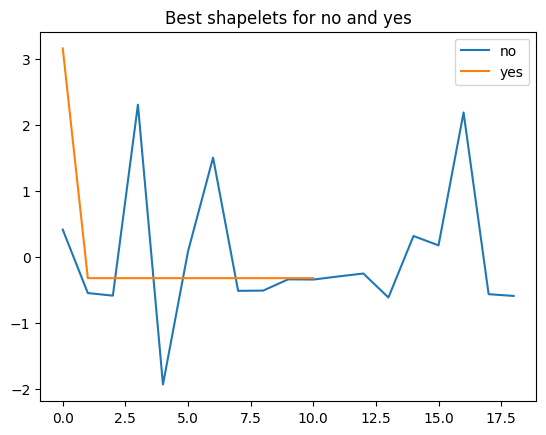

In [24]:
no=rst.shapelets[0]
yes=rst.shapelets[1]

plt.title("Best shapelets for no and yes")
plt.plot(no[6], label="no")
plt.plot(yes[6], label="yes")
plt.legend()

In [21]:
rf = RandomForestClassifier(random_state=10)
rf.fit(st, y_train)


RandomForestClassifier(random_state=10)

In [22]:
tr_test = rst.transform(x_test)

preds = rf.predict(tr_test)
print(" Shapelets + random forest acc = ", accuracy_score(preds, y_test))


 Shapelets + random forest acc =  0.9985
